In [1]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the numpy, pandas and matplot library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt  


# the commonly used alias for seaborn is sns
import seaborn as sns

# set a seaborn style of your taste
sns.set_style("whitegrid")

# data
uber = pd.read_csv("C:/Users/hp/Downloads/Uber Request Data.csv")

In [3]:
print(uber.info())
print("Shape of the data: \n",uber.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null object
Driver id            4095 non-null float64
Status               6745 non-null object
Request timestamp    6745 non-null object
Drop timestamp       2831 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 316.2+ KB
None
Shape of the data: 
 (6745, 6)


In [4]:
# Sum of null values
# We will not drop or replace nan values as the are required for analysis (represent No cars available & cancelled status)

uber.isnull().sum()

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64

In [5]:
# Fixing data quality issues
# Replacing the "/" with "-" in time stamp columns

uber["Request timestamp"]=uber["Request timestamp"].str.replace("/","-")
uber["Drop timestamp"]=uber["Drop timestamp"].str.replace("/","-")

In [6]:
#Request timestamp & Drop timestamp are objects by default, changing them to proper format datetime

uber['Request timestamp'] = pd.to_datetime(uber['Request timestamp'], dayfirst = True)
uber['Drop timestamp'] = pd.to_datetime(uber['Drop timestamp'], dayfirst = True)

In [7]:
# extracting date,hours from request & drop timestamp

uber["Request_hour"] = uber["Request timestamp"].dt.hour
uber["Request_date"] = uber["Request timestamp"].dt.date
uber["Request_time"] = uber["Request timestamp"].dt.time
uber["Drop_time"] = uber["Drop timestamp"].dt.time

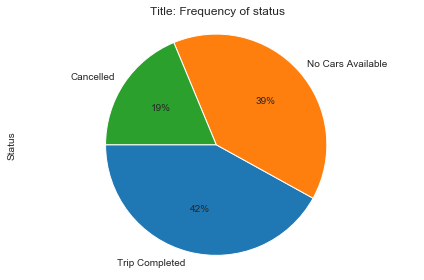

Text(0.5,1,'Frequency of Status')

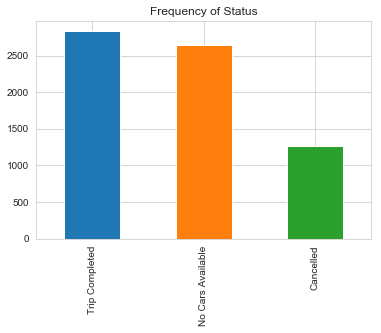

In [8]:
# plotting frequency of requests that get cancelled, show no cars available & trip completed

# A pie chart is good option for plotting frequency
uber.Status.value_counts().plot(kind="pie",startangle = 180,radius=1.5,autopct="%0.0f%%",shadow=False)
plt.title("Title: Frequency of status")
plt.tight_layout()
plt.axis("equal")
plt.show()

# A bar plot to show the count of request that get cancelled, show no cars available & trip completed
uber.Status.value_counts().plot(kind='bar',);plt.title("Frequency of Status")

In [9]:
#For identifying the most problematic types of requests (city to airport / airport to city etc.) and the time slots (early mornings, late evenings etc.) using plots

# First Creating timeslots according to hours
# Next Creating Request type ( Airport to city & City to Airport)

uber["Timeslots"] = pd.cut(uber.Request_hour,[-1,5,8,12,17,24], labels=['Night','Early morning','Morning(Rush Hour)','Afternoon','Evening(Rush Hour)'])
uber["Request_type"] = uber["Pickup point"].apply(lambda x:"Airport to City" if x == "Airport" else "City to Airport")

Text(0.5,1,'Most problematic Request Type & Timeslot - City & Airport')

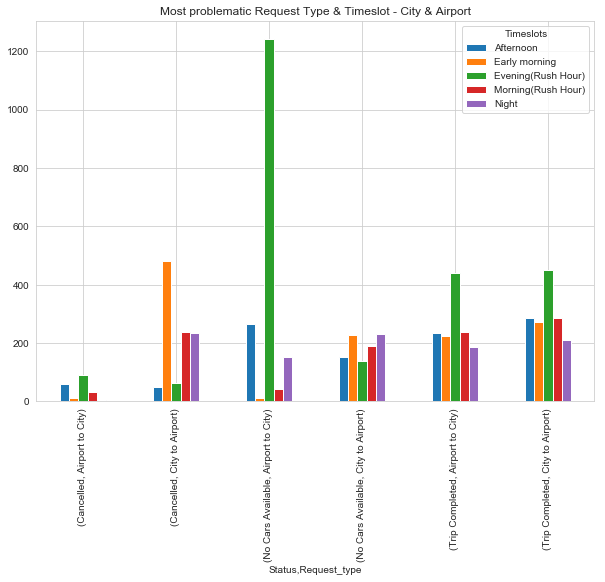

In [10]:
# Creating a new Dataframe by grouping Status, Request type & timeslots, then plotting a bar plot which identifies the Most problematic types of requests & timeslot

uber1 = uber.groupby(["Status","Request_type"]).Timeslots.value_counts().unstack()
uber1.plot(kind="bar",align='center', alpha=1.0,figsize=(10,7));plt.title("Most problematic Request Type & Timeslot - City & Airport")


In [11]:
#Finding the gap between supply and demand
#Creating a groupby object on basis of timeslots and status and assigning the value to new df uber2
# deriving required columns such as demand, supply & gap
#Demand = all status i.e. Cancelled+No Cars Available+Trip Completed
#Supply = Trip Completed
#Gap = Demand - Supply(Trip Completed)

uber2 = uber.groupby(['Timeslots', 'Status']).count()['Request id'].unstack()
uber2 ['Demand'] = uber2 ['Cancelled'] + uber2 ['No Cars Available'] + uber2 ['Trip Completed']
uber2 ['Supply'] = uber2 ['Trip Completed']
uber2 ['Gap'] = uber2 ['Demand'] - uber2 ['Supply']
uber2

Status,Cancelled,No Cars Available,Trip Completed,Demand,Supply,Gap
Timeslots,,,,,,
Night,241,383,399,1023,399,624
Early morning,492,239,496,1227,496,731
Morning(Rush Hour),271,233,525,1029,525,504
Afternoon,107,416,521,1044,521,523
Evening(Rush Hour),153,1379,890,2422,890,1532


Text(0.5,1,'Timeslots vs Demand and Supply Gap')

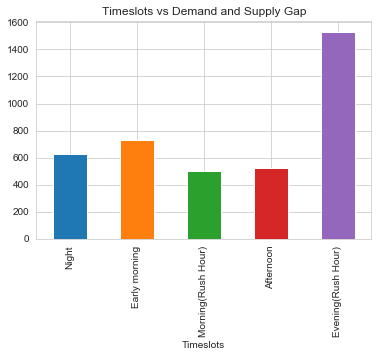

In [12]:
#Finding the time slots when the highest gap exists

uber2['Gap'].plot(kind='bar');plt.title("Timeslots vs Demand and Supply Gap")

In [13]:
#For the types of requests (city-airport or airport-city) for which the gap is the most severe in the identified time slots

# Creating 2 different dataframe uber_City & uber_Airport based on pickup point i.e City & Airport
# Grouping uber_city & uber_airport dataframe based on timeslots and status
# deriving required column such as Demand, Supply & gap 

uber_City = uber.loc[uber['Pickup point'] == 'City']
uber_City = uber_City.groupby(['Timeslots', 'Status']).count()['Request id'].unstack()
uber_City ['Demand'] = uber_City ['Cancelled'] + uber_City ['No Cars Available'] + uber_City ['Trip Completed']
uber_City ['Supply'] = uber_City ['Trip Completed']
uber_City ['Gap'] = uber_City ['Demand'] - uber_City ['Supply']
uber_City

Status,Cancelled,No Cars Available,Trip Completed,Demand,Supply,Gap
Timeslots,,,,,,
Night,235,232,211,678,211,467
Early morning,481,228,273,982,273,709
Morning(Rush Hour),239,189,286,714,286,428
Afternoon,48,151,285,484,285,199
Evening(Rush Hour),63,137,449,649,449,200


In [14]:
uber_Airport = uber.loc[uber['Pickup point'] == 'Airport']
uber_Airport = uber_Airport.groupby(['Timeslots', 'Status']).count()['Request id'].unstack()
uber_Airport ['Demand'] = uber_Airport ['Cancelled'] + uber_Airport ['No Cars Available'] + uber_Airport ['Trip Completed']
uber_Airport ['Supply'] = uber_Airport ['Trip Completed']
uber_Airport ['Gap'] = uber_Airport ['Demand'] - uber_Airport ['Supply']
uber_Airport

Status,Cancelled,No Cars Available,Trip Completed,Demand,Supply,Gap
Timeslots,,,,,,
Night,6,151,188,345,188,157
Early morning,11,11,223,245,223,22
Morning(Rush Hour),32,44,239,315,239,76
Afternoon,59,265,236,560,236,324
Evening(Rush Hour),90,1242,441,1773,441,1332


Text(0.5,1,'Timeslots vs City-Airport Demand and Supply Gap')

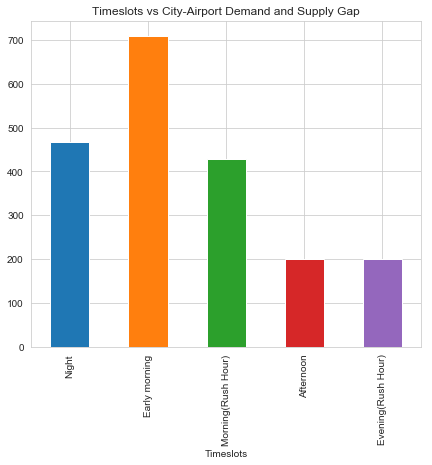

In [15]:
#Finding types of requests (city-airport or airport-city) for which the gap is the most severe in the identified time slots

#For City to Airport
uber_City['Gap'].plot(kind="bar",align='center',  alpha=1.0,figsize=(7,6));plt.title("Timeslots vs City-Airport Demand and Supply Gap")

Text(0.5,1,'Timeslots vs Airport-City Demand and Supply Gap')

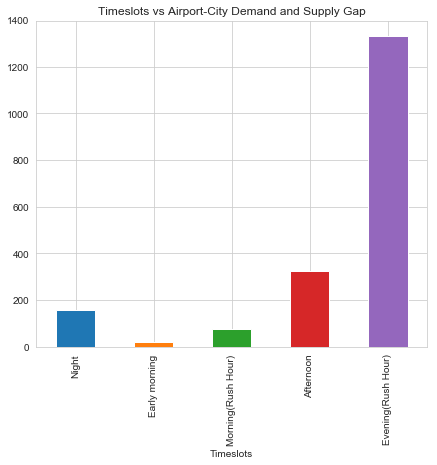

In [16]:
#For Airport to City
uber_Airport['Gap'].plot(kind="bar",align='center', alpha=1.0,figsize=(7,6));plt.title("Timeslots vs Airport-City Demand and Supply Gap")


Text(0.5,1,'Status of Request on Hourly Basis')

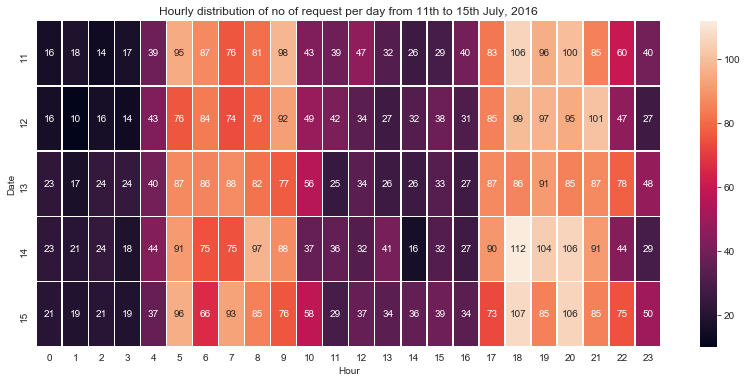

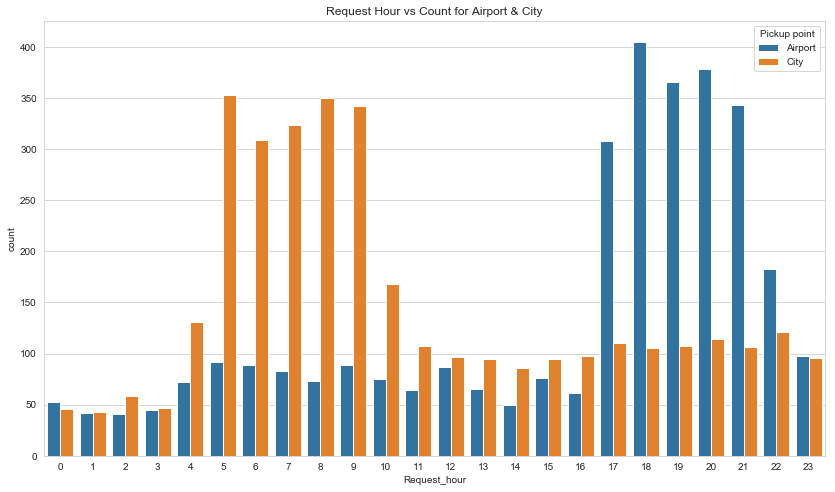

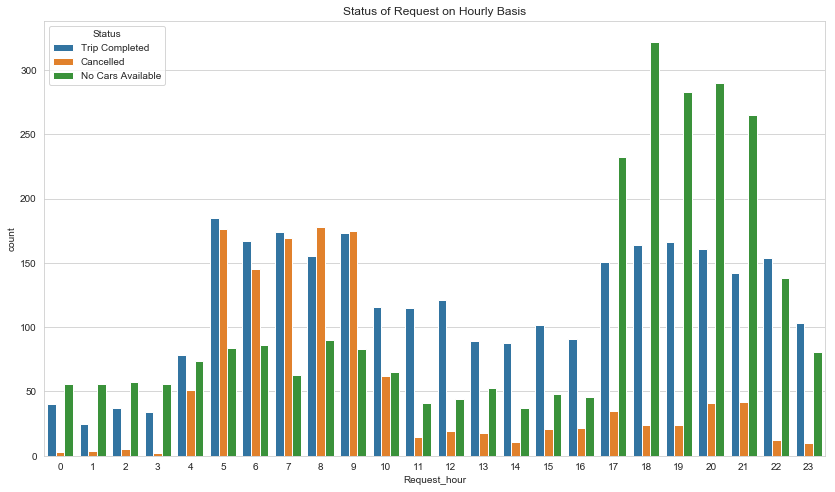

In [17]:
# Analysing the time of a day when the request is highest

uber["Request_Day"] = uber["Request timestamp"].dt.day
uber_day = uber.groupby(["Request_Day","Request_hour"]).count()['Request id'].unstack()
f, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(uber_day, annot = True, fmt="d", linewidths =.5, ax=ax);
plt.title("Hourly distribution of no of request per day from 11th to 15th July, 2016")
plt.xlabel("Hour")
plt.ylabel("Date")

# Analysis the time of a day when the request is highest on pickup point basis
plt.figure(figsize=(14,8))
sns.countplot(x='Request_hour',hue='Pickup point',data=uber);plt.title("Request Hour vs Count for Airport & City")

# Analysis Status of request on hourly basis
plt.figure(figsize=(14,8))
sns.countplot(x='Request_hour',hue='Status',data=uber);plt.title("Status of Request on Hourly Basis")

Text(0.5,1,'Distribution of Cab Request by Date')

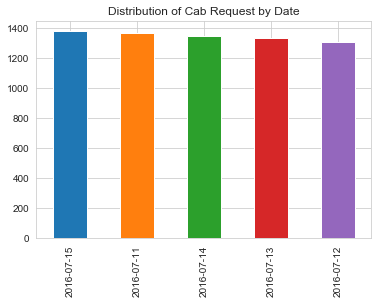

In [18]:
#Distribution of cab request by Date

uber.Request_date.value_counts().plot(kind='bar',);plt.title("Distribution of Cab Request by Date")

Text(0.5,1,'Distribution of All Cab Request by Pickup Point sorted by Date')

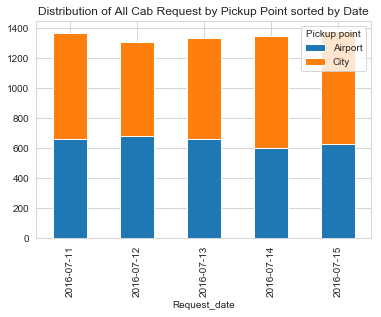

In [19]:
#Distribution of all cab requested by pickup point sorted by date

uber.groupby('Request_date')['Pickup point']\
    .value_counts()\
    .unstack(level=1)\
    .plot.bar(stacked=True);plt.title("Distribution of All Cab Request by Pickup Point sorted by Date")

Text(0.5,1,'Timeslots vs Request Type')

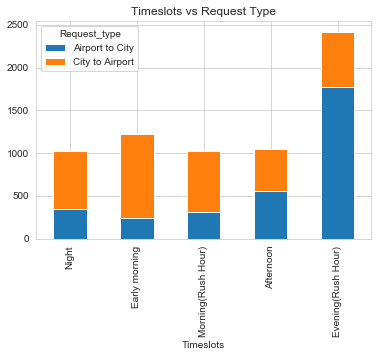

In [20]:
#Distribution of the fraction of request from Airport to city & City to airport for all time slots

uber.groupby('Timeslots')['Request_type']\
    .value_counts()\
    .unstack(level=1)\
    .plot.bar(stacked=True);plt.title("Timeslots vs Request Type")

Text(0.5,1,'Timeslots vs Status')

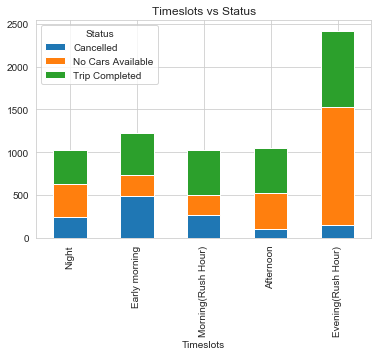

In [21]:
#Distribution of the fraction of request that gets completed or is cancelled or for which there is no cars available in each timeslot

uber.groupby('Timeslots')['Status']\
    .value_counts()\
    .unstack(level=1)\
    .plot.bar(stacked=True);plt.title("Timeslots vs Status")

Text(0.5,1,'Driver ID vs No.of Cancellation')

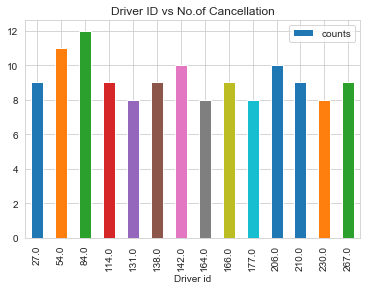

In [22]:
#Analysing Driver id to see if there is an outlier i.e a particular driver who is cancelling huge number of requests
#Creating new dataframe uber_driver by indexing status column with value "cancelled" and grouping the new df based on driver id & status
#Selecting only those driver ids whose cancelled count is more than 8 & plotting the same to identify outliers

uber_driver =uber.loc[uber['Status'] == 'Cancelled']
uber_driver = uber_driver.groupby(['Driver id','Status']).size().reset_index(name='counts')
uber_driver = uber_driver.loc[uber_driver.counts >=8]
uber_driver.plot(x='Driver id', y='counts', kind='bar');plt.title("Driver ID vs No.of Cancellation")